In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# data_kg = pd.read_csv('../../KG0/PreprocessData/data/KG0_HBsRE.csv')
data_kg = pd.read_csv('../PreprocessData/data/target.csv')
path = '../PatternDetection/clusteringMeasures/TransH/SemEP_50/clusters/'  #Kmeans, METIS, SemEP


list_donor = []
entries = os.listdir(path)
for file in entries:
    cls = pd.read_csv(path + file, delimiter="\t", header=None)
    cls.columns = ['ClinicalRecord']
    data_kg.loc[data_kg.ClinicalRecord.isin(cls.ClinicalRecord), 'cluster'] = 'Cluster ' + file[:-4].split('-')[1]
    list_donor = list_donor+list(cls.ClinicalRecord)
data_kg = data_kg.loc[data_kg.ClinicalRecord.isin(list_donor)]
# data_kg = data_kg.astype({'cluster':'int'})
data_kg = data_kg.loc[data_kg.Relapse!='entity:UnKnown']
display(data_kg.head(), data_kg.shape)

,ClinicalRecord,Relapse,cluster
0,entity:718710_ClinicalRecord,entity:No_Progression,Cluster 0
1,entity:2432630_ClinicalRecord,entity:Progression,Cluster 0
2,entity:583611_ClinicalRecord,entity:No_Progression,Cluster 0
3,entity:329355_ClinicalRecord,entity:Progression,Cluster 1
4,entity:760472_ClinicalRecord,entity:Progression,Cluster 1


(962, 3)

In [2]:
replacement_mapping_dict = {'entity:No_Progression': 'No relapse',
                            'entity:Relapse': 'Relapse',
                           'entity:Progression': 'Relapse'}
data_kg['Relapse'].replace(replacement_mapping_dict, inplace=True)
display(data_kg.head(), data_kg.shape)

,ClinicalRecord,Relapse,cluster
0,entity:718710_ClinicalRecord,No relapse,Cluster 0
1,entity:2432630_ClinicalRecord,Relapse,Cluster 0
2,entity:583611_ClinicalRecord,No relapse,Cluster 0
3,entity:329355_ClinicalRecord,Relapse,Cluster 1
4,entity:760472_ClinicalRecord,Relapse,Cluster 1


(962, 3)

In [4]:
df = data_kg[['Relapse', 'cluster']]
q = df.groupby(['Relapse', 'cluster']).size().reset_index(name='count_values')
# Display the resulting dataframe
df_reset = q.reset_index(drop=True)
df_reset

,Relapse,cluster,count_values
0,No relapse,Cluster 0,180
1,No relapse,Cluster 1,66
2,Relapse,Cluster 0,371
3,Relapse,Cluster 1,345


In [5]:
data_kg.cluster.value_counts()

cluster
Cluster 0    551
Cluster 1    411
Name: count, dtype: int64

In [6]:
a = df_reset.loc[df_reset.Relapse=='No relapse']
b = df_reset.loc[df_reset.Relapse=='Relapse']
a.count_values = a.count_values/246
b.count_values = b.count_values/716

# a = df_reset.loc[df_reset.cluster=='Cluster 0']
# b = df_reset.loc[df_reset.cluster=='Cluster 1']
# a.count_values = a.count_values/551
# b.count_values = b.count_values/411

df_reset = pd.concat([a, b])
df_reset

C:\Users\rivasa\AppData\Local\Temp\ipykernel_32460\3159611576.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a.count_values = a.count_values/246
C:\Users\rivasa\AppData\Local\Temp\ipykernel_32460\3159611576.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b.count_values = b.count_values/716


,Relapse,cluster,count_values
0,No relapse,Cluster 0,0.731707
1,No relapse,Cluster 1,0.268293
2,Relapse,Cluster 0,0.518156
3,Relapse,Cluster 1,0.481844


C:\Users\rivasa\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(0.0, 0.9)

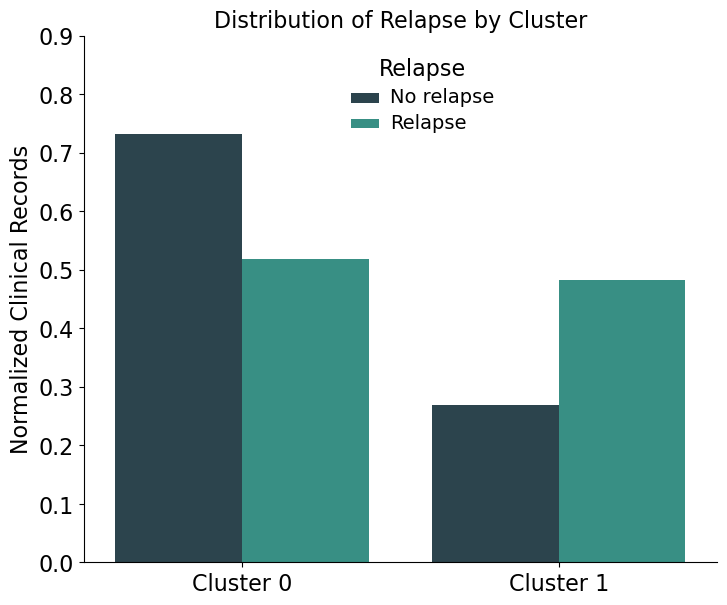

In [7]:
g = sns.catplot(df_reset, kind="bar",
    x="cluster", y="count_values", hue='Relapse',
                height=6, aspect=1.2, palette=['#264653', '#2A9D8F'])
legend = g._legend  # Access the legend object
# legend.set_title("Legend Title")  # Set the legend title
# Set the legend's fontsize and other properties
legend.get_title().set_fontsize(16)  # Set the title font size
legend.get_texts()[0].set_fontsize(14)  # Set the label font size for the first item
legend.get_texts()[1].set_fontsize(14)  # Set the label font size for the second item
# Change the legend position
legend.set_bbox_to_anchor((0.6, 0.85))  # Adjust the position as needed

g.set_axis_labels("", "Normalized Clinical Records", fontsize=16)
plt.title('Distribution of Relapse by Cluster', fontsize=16)
# ax.set_ylabel("Parameter values",fontsize=16)
plt.tick_params(labelsize=16)
plt.ylim(0, .9)
# plt.savefig('Plots/Kmeans_norm_v2.pdf', bbox_inches='tight', format='pdf', transparent=True)
# plt.savefig('Plots/METIS_norm_v2.pdf', bbox_inches='tight', format='pdf', transparent=True)
# plt.savefig('Plots/SemEP_norm_v2.pdf', bbox_inches='tight', format='pdf', transparent=True)


# Descriptive Analysis

In [3]:
from rdflib import Graph
import pandas as pd
from rdflib.plugins.sparql.processor import SPARQLResult

def sparql_results_to_df(results: SPARQLResult) -> pd.DataFrame:
    """
    Export results from an rdflib SPARQL query into a `pandas.DataFrame`,
    using Python types. See https://github.com/RDFLib/rdflib/issues/1179.
    """
    return pd.DataFrame(
        data=([None if x is None else x.toPython() for x in row] for row in results),
        columns=[str(x) for x in results.vars],
    )

In [4]:
path = '../../store_data/P4-LUCAT/'
g = Graph()
g.parse(path + "KG0.nt", format="nt")

<Graph identifier=N6e2dc9e28c914cb7829a6e9babbd31dc (<class 'rdflib.graph.Graph'>)>

In [5]:
def get_triples(graph):
    query = """    
    select distinct ?ClinicalRecord ?Biomarker
    where {
        ?ClinicalRecord <http://research.tib.eu/p4-lucat/vocab/hasBiomarker> ?Biomarker
        }
        """
    qres = graph.query(query)
    triples = sparql_results_to_df(qres)
    triples.replace('http://research.tib.eu/p4-lucat/entity/', 'entity:', regex=True, inplace=True)
#     'http://research.tib.eu/p4-lucat/entity/1201946_ClinicalRecord'
    return triples

In [6]:
biomarker = get_triples(g)
replacement_mapping_dict = {'entity:': '',}
biomarker['Biomarker'].replace(replacement_mapping_dict, regex=True, inplace=True)
biomarker

,ClinicalRecord,Biomarker
0,entity:2577622_ClinicalRecord,PDL1
1,entity:2831180_ClinicalRecord,PDL1
2,entity:1079447_ClinicalRecord,PDL1
3,entity:692569_ClinicalRecord,PDL1
4,entity:2800873_ClinicalRecord,PDL1
...,...,...
1579,entity:339453_ClinicalRecord,Otros
1580,entity:1089307_ClinicalRecord,MET
1581,entity:2834441_ClinicalRecord,MET
1582,entity:2338663_ClinicalRecord,MET


### Distribution of Biomarker by Relapse

In [7]:
data_kg.Relapse.value_counts()

Relapse
Relapse       716
No relapse    246
Name: count, dtype: int64

In [9]:
non_biomarker = data_kg.merge(biomarker, how = 'outer' , on='ClinicalRecord', indicator=True).loc[lambda x : x['_merge']=='left_only']
biom = data_kg.merge(biomarker, how = 'outer' , on='ClinicalRecord', indicator=True).loc[lambda x : x['_merge']=='both'][['ClinicalRecord', 'Relapse']]
biom.drop_duplicates(inplace=True)
non_biomarker

,ClinicalRecord,Relapse,Biomarker,_merge
0,entity:718710_ClinicalRecord,No relapse,NaN,left_only
1,entity:2432630_ClinicalRecord,Relapse,NaN,left_only
10,entity:760472_ClinicalRecord,Relapse,NaN,left_only
20,entity:592843_ClinicalRecord,Relapse,NaN,left_only
28,entity:633972_ClinicalRecord,Relapse,NaN,left_only
...,...,...,...,...
1694,entity:2819509_ClinicalRecord,Relapse,NaN,left_only
1709,entity:640679_ClinicalRecord,Relapse,NaN,left_only
1714,entity:375428_ClinicalRecord,Relapse,NaN,left_only
1717,entity:158421_ClinicalRecord,Relapse,NaN,left_only


In [10]:
biom.Relapse.value_counts()

Relapse
Relapse       378
No relapse     50
Name: count, dtype: int64

In [11]:
non_biomarker.Relapse.value_counts()

Relapse
Relapse       338
No relapse    196
Name: count, dtype: int64

In [35]:
378+50

428

C:\Users\rivasa\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


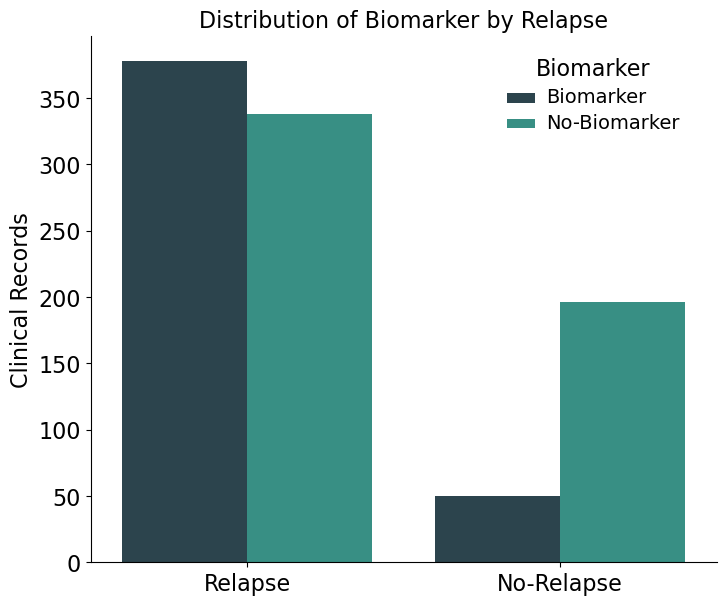

In [34]:
data = [['Relapse', 'Biomarker', 378], ['Relapse', 'No-Biomarker', 338], ['No-Relapse', 'Biomarker', 50], 
        ['No-Relapse', 'No-Biomarker', 196]]
df = pd.DataFrame(columns=['Relapse', 'Biomarker', 'count_values'], data=data)

g = sns.catplot(df, kind="bar",
    x="Relapse", y="count_values", hue='Biomarker',
                height=6, aspect=1.2, palette=['#264653', '#2A9D8F'])
legend = g._legend  # Access the legend object
# Set the legend's fontsize and other properties
legend.get_title().set_fontsize(16)  # Set the title font size
legend.get_texts()[0].set_fontsize(14)  # Set the label font size for the first item
legend.get_texts()[1].set_fontsize(14)  # Set the label font size for the second item
# Change the legend position
legend.set_bbox_to_anchor((0.8, 0.85))  # Adjust the position as needed

g.set_axis_labels("", "Clinical Records", fontsize=16)
plt.title('Distribution of Biomarker by Relapse', fontsize=16)
plt.tick_params(labelsize=16)
# plt.ylim(0, .9)
plt.savefig('Plots/Biomarker_by_Relapse.pdf', bbox_inches='tight', format='pdf', transparent=True)

In [19]:
biomarker = pd.merge(biomarker, data_kg, on='ClinicalRecord')[['Biomarker', 'Relapse', 'cluster']]
biomarker

,Biomarker,Relapse,cluster
0,PDL1,Relapse,Cluster 1
1,PDL1,Relapse,Cluster 0
2,ROS1,Relapse,Cluster 0
3,ALK,Relapse,Cluster 0
4,EGFR,Relapse,Cluster 0
...,...,...,...
1180,EGFR,Relapse,Cluster 0
1181,Otros,Relapse,Cluster 0
1182,Otros,Relapse,Cluster 0
1183,Otros,Relapse,Cluster 0


In [20]:
biomarker.Biomarker.value_counts()
# biomarker.ClinicalRecord.value_counts()

Biomarker
EGFR     383
ALK      310
ROS1     192
PDL1     172
BRAF      76
RET       35
KRAS       8
Otros      5
MET        3
HER2       1
Name: count, dtype: int64

In [92]:
q = biomarker.groupby(['Biomarker', 'Relapse', 'cluster'])[['Biomarker', 'Relapse', 'cluster']].count()
q = q[['Biomarker']]
q.columns = ['count_values']
df_reset = q.reset_index()
df_reset

,Biomarker,Relapse,cluster,count_values
0,ALK,No relapse,Cluster 0,6
1,ALK,No relapse,Cluster 1,34
2,ALK,Relapse,Cluster 0,64
3,ALK,Relapse,Cluster 1,206
4,BRAF,No relapse,Cluster 1,9
5,BRAF,Relapse,Cluster 0,5
6,BRAF,Relapse,Cluster 1,62
7,EGFR,No relapse,Cluster 0,10
8,EGFR,No relapse,Cluster 1,37
9,EGFR,Relapse,Cluster 0,89


# Normalise

In [98]:
print(biomarker.loc[biomarker.cluster=='Cluster 0'].Relapse.value_counts())
biomarker.loc[biomarker.cluster=='Cluster 1'].Relapse.value_counts()

Relapse
Relapse       215
No relapse     21
Name: count, dtype: int64


Relapse
Relapse       822
No relapse    127
Name: count, dtype: int64

In [93]:
a = df_reset.loc[(df_reset.cluster=='Cluster 0') & (df_reset.Relapse=='Relapse')]
b = df_reset.loc[(df_reset.cluster=='Cluster 0') & (df_reset.Relapse=='No relapse')]
a.count_values = a.count_values/215
b.count_values = b.count_values/21
c = pd.concat([a, b])

a = df_reset.loc[(df_reset.cluster=='Cluster 1') & (df_reset.Relapse=='Relapse')]
b = df_reset.loc[(df_reset.cluster=='Cluster 1') & (df_reset.Relapse=='No relapse')]
a.count_values = a.count_values/822
b.count_values = b.count_values/127
df_reset = pd.concat([c, a, b])
df_reset

C:\Users\rivasa\AppData\Local\Temp\ipykernel_32808\1258455372.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a.count_values = a.count_values/215
C:\Users\rivasa\AppData\Local\Temp\ipykernel_32808\1258455372.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b.count_values = b.count_values/21
C:\Users\rivasa\AppData\Local\Temp\ipykernel_32808\1258455372.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,Biomarker,Relapse,cluster,count_values
2,ALK,Relapse,Cluster 0,0.297674
5,BRAF,Relapse,Cluster 0,0.023256
9,EGFR,Relapse,Cluster 0,0.413953
13,KRAS,Relapse,Cluster 0,0.004651
16,Otros,Relapse,Cluster 0,0.013953
20,PDL1,Relapse,Cluster 0,0.125581
23,RET,Relapse,Cluster 0,0.004651
27,ROS1,Relapse,Cluster 0,0.116279
0,ALK,No relapse,Cluster 0,0.285714
7,EGFR,No relapse,Cluster 0,0.476190


C:\Users\rivasa\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


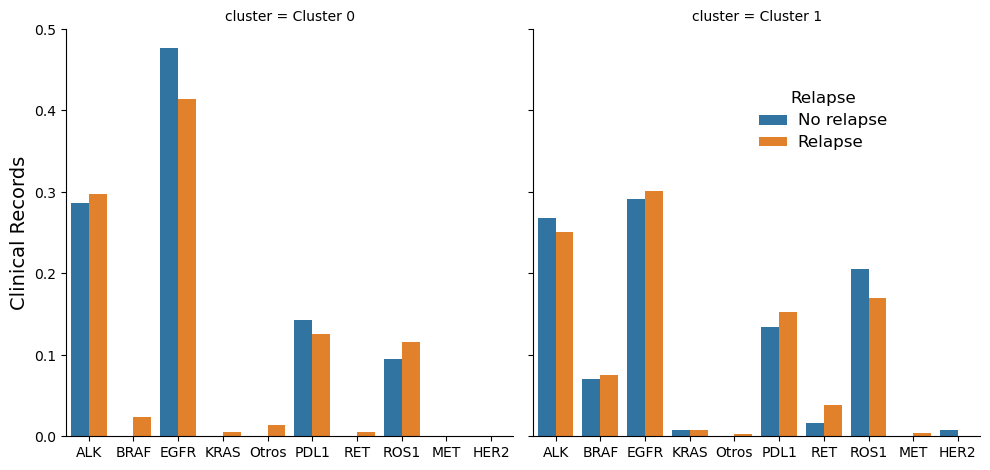

In [97]:
x_order = ['LowRange', 'MiddleRange', 'HighRange']
y_order = ['No relapse', 'Relapse']
g = sns.catplot(df_reset, kind="bar",
    x="Biomarker", y="count_values", col="cluster",
    hue='Relapse', height=5, aspect=1., hue_order=y_order)#, hue_order=y_order, col_order=x_order) #height=4, aspect=.5,
legend = g._legend  # Access the legend object
# legend.set_title("Legend Title")  # Set the legend title
# Set the legend's fontsize and other properties
legend.get_title().set_fontsize(12)  # Set the title font size
legend.get_texts()[0].set_fontsize(12)  # Set the label font size for the first item
legend.get_texts()[1].set_fontsize(12)  # Set the label font size for the second item
# Change the legend position
legend.set_bbox_to_anchor((0.8, 0.7))  # Adjust the position as needed

g.set_axis_labels("", "Clinical Records", fontsize=14)
# plt.title('Distribution of Relapse by Cluster', fontsize=16)
# plt.tick_params(labelsize=16)

# plt.savefig('Plots/Biomarker_by_Cluster.pdf', bbox_inches='tight', format='pdf', transparent=True)
plt.savefig('Plots/Biomarker_by_Cluster_norm.pdf', bbox_inches='tight', format='pdf', transparent=True)